In [1]:
!pip install ultralytics opencv-python-headless
# Import the Ultralytics YOLO class
from ultralytics import YOLO

# Load YOLOv11 small model
model = YOLO('yolo11s.pt')

#Set confidence threshold (used during predict)
model.conf = 0.3


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


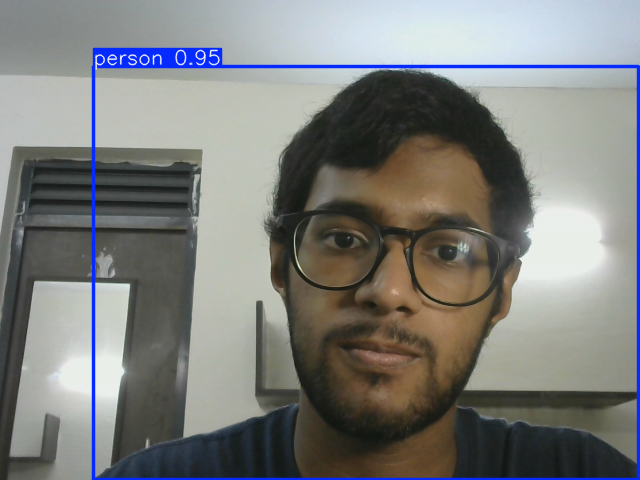

In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
from IPython.display import display, clear_output
from PIL import Image
from ultralytics import YOLO

# Load YOLOv11 model
model = YOLO('yolo11s.pt')

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

frame_count = 0  # Limit frame count for testing in Jupyter

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Run detection
    results = model(frame)

    # Plot (annotate) results on the frame
    annotated_frame = results[0].plot()

    # Convert to RGB and show in Jupyter
    rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb_frame)
    clear_output(wait=True)
    display(img)

    # Stop after 150 frames
    frame_count += 1
    if frame_count >= 150:
        break

# Release webcam
cap.release()


# LOADING THE SAME MODEL WE TRAINED IN THE YOLOV5 FILE

In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


In [4]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archive"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transforms
transform = transforms.Compose([
    transforms.Grayscale(),  # FER images are grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x48x48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # 32x24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x6x6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [6]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [7]:
import warnings
warnings.filterwarnings('ignore')

from torchvision import models
import torch.nn as nn

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes=len(classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Recreate the model architecture
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Load the saved weights
model_path = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\best_googlenet_emotion_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))


# Set to evaluation mode
model.eval()
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from collections import deque, Counter
from torchvision import transforms
import warnings
from ultralytics import YOLO

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv11s model (Ultralytics)
yolo_model = YOLO("yolo11s.pt")
yolo_model.to(device)

# Load the GoogLeNet emotion model and classes
model_path = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\best_googlenet_emotion_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)
emotion_model = model
emotion_model.eval()

emotion_labels = classes  # e.g. ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Image transform for emotion model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Buffer for smoothing predictions
prediction_buffer = deque(maxlen=30)

# --- Webcam Capture ---
cap = cv2.VideoCapture(0)
print("🟢 Starting real-time emotion detection...")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # YOLOv11s detection
    results = yolo_model(frame)
    boxes = results[0].boxes  # First image/frame in the batch

    if boxes is not None:
        for box in boxes:
            cls = int(box.cls.cpu().item())
            if cls == 0:  # Class 0 is person in COCO
                xyxy = box.xyxy.cpu().numpy().astype(int)[0]
                x1, y1, x2, y2 = xyxy

                # Crop face region from detected person box
                face = frame[y1:y2, x1:x2]
                try:
                    face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                    face_tensor = transform(face_pil).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = emotion_model(face_tensor)
                        if isinstance(output, tuple):
                            output = output[0]
                        pred = torch.argmax(output, dim=1).item()
                        pred_label = emotion_labels[pred]

                    # Append prediction to buffer for smoothing
                    prediction_buffer.append(pred_label)

                    # Get most common prediction in buffer
                    smoothed_prediction = Counter(prediction_buffer).most_common(1)[0][0]

                    # Draw bounding box + label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, smoothed_prediction.upper(), (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                except Exception as e:
                    print("Skipping face:", e)
                break  # Remove this break if you want to process all persons

    # Show annotated frame
    cv2.imshow("Real-Time Emotion Detection", frame)

    # Exit loop on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("🛑 Stopped.")


🟢 Starting real-time emotion detection...

0: 480x640 1 person, 13.6ms
Speed: 1.2ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12.8ms
Speed: 1.6ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 15.1ms
Speed: 1.7ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.8m